Android gameplay footage (Hill Climb Racing) via scrcpy → virtual cam → Python



------

# Attempt 01

--------

# Running the model

In [ ]:
import cv2
import subprocess
import time
import torch
import numpy as np
from IPython.core.display_functions import clear_output
from PIL import Image


In [ ]:
# === CONFIG ===
ACCEL_POS = (200, 850, 240, 850, 500)  #(x1, y1, x2, y2)
BRAKE_POS = (2115, 850, 2200, 850, 500)  #(x1, y1, x2, y2)
VIDEO_DEVICE = '/dev/video10'
HOLD_DURATION_MS = 10_000  # 10 seconds (long enough to cover many steps)
TAP_DURATION_MS = 1  # 10 seconds (long enough to cover many steps)

....

In [ ]:
# === HELPERS ===
def start_hold(x, y, duration_ms=HOLD_DURATION_MS):
    """Start a long press in background (non-blocking)"""
    return subprocess.Popen([
        'adb', 'shell', 'input', 'swipe',
        str(x), str(y), str(x), str(y), str(duration_ms)
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


def stop_hold(proc):
    """Gracefully stop a running hold"""
    if proc is not None:
        proc.terminate()
        try:
            proc.wait(timeout=0.1)
        except subprocess.TimeoutExpired:
            proc.kill()


def get_action_from_model(frame):
    """
    Replace this with your PyTorch model.
    Must return one of: "accel", "brake", "none"
    """
    # Placeholder: random action (replace with real inference)
    time.sleep(0.02)  # Simulate model latency (~20ms)
    return np.random.choice(["accel", "brake", "none"])


def get_frame(cap):
    """Grab single frame from video device"""
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError("Failed to read frame")
    return frame


def resize_img(frame, width=84):
    """Resize frame to given width, preserving aspect ratio (height auto-scaled)"""
    h, w = frame.shape[:2]
    new_w = width
    new_h = int(h * (new_w / w))
    resized = cv2.resize(frame, (new_w, new_h))
    return resized


def ocr_distance(frame):
    """Extract distance from frame via OCR. Return float distance in meters."""
    h, w = frame.shape[:2]

    # ADJUST THESE CROP COORDINATES TO YOUR SCREEN
    x1, x2 = 1800, 2200
    y1, y2 = 20, 60

    # Fix bounds
    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        print("OCR: Invalid crop region")
        return 0.0

    roi = frame[y1:y2, x1:x2]

    # Only show if valid
    if roi.size > 0:
        cv2.imshow("OCR Region", roi)
        cv2.waitKey(1)

    # TODO: Add OCR here later
    return 0.0

## stream the screen though adb

In [ ]:
import subprocess
import time
import cv2

# Start scrcpy in background
scrcpy_proc = subprocess.Popen([
    'scrcpy', f'--v4l2-sink={VIDEO_DEVICE}',
    '--no-window', '--max-size', '720', '--stay-awake'
], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

time.sleep(2)

cap = cv2.VideoCapture(VIDEO_DEVICE)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open {VIDEO_DEVICE}")

## OCR distance

### test: ocr distance from screen using `easyocr`

In [ ]:
from PIL import Image
import easyocr

reader = easyocr.Reader(['en'], gpu=True)


def ocr_distance(frame):
    """Extract distance from frame via OCR. Return float distance in meters."""
    h, w = frame.shape[:2]

    # ADJUST THESE CROP COORDINATES TO YOUR SCREEN
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    # Fix bounds
    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Preprocessing for better OCR:
    # Preprocessing for better OCR:
    # Preprocessing for better OCR:
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Display (for debugging in notebook)
    display(Image.fromarray(thresh, 'L'))

    # Run EasyOCR on preprocessed image
    try:
        result = reader.readtext(thresh, detail=0, allowlist='0123456789m')
        if result:
            text = result[0].strip().lower().replace('m', '')
            if text.isdigit():
                print("OCR Distance: ", text)
                return int(text)
    except Exception as e:
        pass
    return 0

# while True:
#     clear_output()
#
#     # # ret, frame = cap.read()
#     frame = get_frame(cap)
#     # rframe = resize_img(frame)
#     # Image.fromarray(frame)
#     # Image.fromarray(rframe)
#     ocr_distance(frame)
#     # len(frame)
#     time.sleep(50 / 1000)


### test: ocr using PaddleOCR

In [ ]:
from paddleocr import PaddleOCR

ocr_engine = PaddleOCR(use_angle_cls=False, lang='en')

In [ ]:
# ADD ONCE AT TOP (after imports)
from paddleocr import PaddleOCR

ocr_engine = PaddleOCR(use_angle_cls=False, lang='en')


def ocr_distance(frame):
    h, w = frame.shape[:2]
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Correct call: .ocr(), NOT callable
    result = ocr_engine.ocr(roi, cls=False)
    if result and len(result[0]) > 0:
        text = result[0][0][1][0]
        num_str = ''.join(filter(str.isdigit, text))
        if num_str:
            return int(num_str)
    return 0

# while True:
#     clear_output()
#
#     # # ret, frame = cap.read()
#     frame = get_frame(cap)
#     # rframe = resize_img(frame)
#     # Image.fromarray(frame)
#     # Image.fromarray(rframe)
#     ocr_distance(frame)
#     # len(frame)
#     time.sleep(500 / 1000)

### test: ocr using Tesseract-OCR

In [ ]:
# ADD ONCE AT TOP (after imports)
import pytesseract

In [ ]:

def ocr_distance(frame):
    h, w = frame.shape[:2]
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Preprocess for Tesseract: B&W, high contrast
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    thresh = cv2.bitwise_not(thresh)
    display(Image.fromarray(thresh))

    # Run Tesseract: only digits and 'm'
    text = pytesseract.image_to_string(
        thresh,
        config='--psm 8 --oem 0 -c tessedit_char_whitelist=0123456789m'
    )
    num_str = ''.join(filter(str.isdigit, text))
    return int(num_str) if num_str else 0


while True:
    clear_output()

    # # ret, frame = cap.read()
    frame = get_frame(cap)
    # rframe = resize_img(frame)
    # Image.fromarray(frame)
    # Image.fromarray(rframe)
    print(ocr_distance(frame))
    # len(frame)
    time.sleep(500 / 1000)
    break

### test: ocr using template

In [ ]:
# load 0-9 character templates, for ocr'ing the distance from screen

import os


def load_chr_templates():
    templates = {}
    for i in range(10):
        path = f"assets/chr_{i}.png"
        if os.path.exists(path):
            img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # loads BGRA
            templates[str(i)] = img
    return templates


chr_templates = load_chr_templates()

In [ ]:
from PIL import Image


def ocr_distance(frame):
    h, w = frame.shape[:2]
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Convert ROI to grayscale (once)
    # roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY).astype(np.float32)
    roi_gray = roi

    display(Image.fromarray(roi_gray))

    text = ""
    pos = 0
    while pos < roi_gray.shape[1]:
        best_char = None
        min_diff = float('inf')
        for char, tmpl in chr_templates.items():
            if tmpl is None:
                continue
            h_t, w_t = tmpl.shape[:2]
            if pos + w_t > roi_gray.shape[1] or h_t != roi_gray.shape[0]:
                continue

            # Extract patch (no resize)
            patch = roi_gray[:, pos:pos + w_t]
            if patch.shape != (h_t, w_t):
                continue

            # Extract alpha (opacity) — ignore if < 1/255
            alpha = tmpl[:, :, 3].astype(np.float32) / 255.0
            mask = alpha > 0.01  # treat near-transparent as transparent

            if not np.any(mask):
                continue

            # Template grayscale
            tmpl_gray = cv2.cvtColor(tmpl[:, :, :3], cv2.COLOR_BGR2GRAY).astype(np.float32)

            # Compute absolute difference only on opaque pixels
            diff = np.abs(patch - tmpl_gray) * mask
            total_diff = np.sum(diff) / np.sum(mask)  # normalize by valid pixels

            if total_diff < min_diff and total_diff < 30.0:  # threshold tuned
                min_diff = total_diff
                best_char = char

        if best_char:
            text += best_char
            pos += chr_templates[best_char].shape[1]  # advance by digit width
        else:
            pos += 1  # move 1px if no match

    print(text)
    return int(text) if text.isdigit() else 0


frame = get_frame(cap)
ocr_distance(frame)

### Train custom model for accurate ocr of the distance!

In [ ]:
import os
import hashlib
from PIL import Image


def save_unique_image(img: Image.Image, folder="assets/extracts"):
    os.makedirs(folder, exist_ok=True)

    # Compute hash of the image
    img_bytes = img.tobytes()
    img_hash = hashlib.md5(img_bytes).hexdigest()
    filepath = os.path.join(folder, f"{img_hash}.png")

    # Save only if not exists
    if not os.path.exists(filepath):
        img.save(filepath)
        return True
    return False

In [ ]:
def get_distance_img(frame):
    h, w = frame.shape[:2]
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Preprocess for Tesseract: B&W, high contrast
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    thresh = cv2.bitwise_not(thresh)

    # display(Image.fromarray(thresh))
    return thresh

In [ ]:
frame = get_frame(cap)

# while True:
clear_output()
start_iter = time.perf_counter()

distance_img = Image.fromarray(get_distance_img(frame))
did_save = save_unique_image(distance_img)

display(distance_img)
iter_time = time.perf_counter() - start_iter
print(f"\r took: {iter_time * 1000:.1f} ms | {'saved!' if did_save else ''}", end="")



In [ ]:
def split_digits(roi):
    """
    Split a distance ROI into individual digit images.
    Handles thin digits (like '1') by using morphological closing.
    """
    if len(roi.shape) == 3:
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        gray = roi.copy()

    # Ensure white digits on black background
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Connect nearby pixels (helps thin '1')
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    digit_bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w >= 2 and h >= 8:  # allow very thin but tall (like '1')
            digit_bboxes.append((x, y, w, h))

    digit_bboxes = sorted(digit_bboxes, key=lambda b: b[0])
    digits = []
    for (x, y, w, h) in digit_bboxes:
        digit = roi[y:y + h, x:x + w]
        digits.append(digit)

    return digits


def scale_pil_image(img: Image.Image, scale: int) -> Image.Image:
    """Scale up a PIL image by integer factor using nearest neighbor."""
    return img.resize((img.width * scale, img.height * scale), Image.NEAREST)

In [ ]:
import os
import random
from IPython.display import display
from PIL import Image
import cv2

# Get a random labeled image
labeled_dir = "assets/labeled"
labeled_images = [f for f in os.listdir(labeled_dir) if f.endswith('.png')]
if not labeled_images:
    raise FileNotFoundError("No labeled images found!")

random_img = random.choice(labeled_images)
img_path = os.path.join(labeled_dir, random_img)
print(f"Random image: {random_img}")

# Load image
roi = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
display(scale_pil_image(Image.fromarray(roi), scale=10))

# Split digits
digit_images = split_digits(roi)

# Display each digit in notebook
print("Split digits:")
for i, digit in enumerate(digit_images):
    # Convert OpenCV (BGR/gray) to PIL for notebook display
    pil_img = Image.fromarray(digit)
    pil_img = scale_pil_image(pil_img, scale=10)
    display(pil_img)
    print(f"Digit {i}: shape {digit.shape}")

#### train the moedl on the dataset

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import random
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [ ]:
def char_to_class(c):
    if c == 'm':
        return 10
    return int(c)


def class_to_char(cls):
    if cls == 10:
        return 'm'
    return str(cls)

In [ ]:
# --- 1. DATASET ---
class DigitM_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for filename in os.listdir(root_dir):
            if not filename.endswith('.png'):
                continue
            # Parse full label INCLUDING 'm'
            label_str = filename.split('-')[0]  # "123m-05.png" → "123m"

            img_path = os.path.join(root_dir, filename)
            roi = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if roi is None:
                continue

            digits = split_digits(roi)
            if len(digits) == len(label_str):
                for i, digit_img in enumerate(digits):
                    char = label_str[i]

                    if char == 'm':
                        digit_label = 10
                    else:
                        digit_label = int(char)

                    self.samples.append((digit_img, digit_label))

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        img_resized = cv2.resize(img, (20, 20), interpolation=cv2.INTER_AREA)
        img_pil = Image.fromarray(img_resized)
        if self.transform:
            img_pil = self.transform(img_pil)
        return img_pil, label

    def __len__(self):
        return len(self.samples)


# --- 2. MODEL ---
class DigitClassifier(nn.Module):
    def __init__(self, num_classes=11):  # CHANGED: 11 classes (0-9 + 'm')
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Now 11 outputs
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# --- 3. TRAINING SETUP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = DigitM_Dataset("assets/labeled", transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = DigitClassifier(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# --- 4. TRAIN LOOP ---
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Test
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader):.4f}, "
          f"Test Acc: {100 * correct / total:.2f}%")

In [ ]:
# Assume split_digits() is already defined (from earlier)
def split_digits(roi):
    if len(roi.shape) == 3:
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        gray = roi.copy()
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digit_bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w >= 2 and h >= 8:
            digit_bboxes.append((x, y, w, h))
    digit_bboxes = sorted(digit_bboxes, key=lambda b: b[0])
    digits = []
    for (x, y, w, h) in digit_bboxes:
        digit = roi[y:y + h, x:x + w]
        digits.append(digit)
    return digits


# --- DATASET PROFILING ---
labeled_dir = "assets/labeled"
valid_samples = 0
total_images = 0
mismatches = []

print("🔍 Profiling dataset...\n")

for filename in sorted(os.listdir(labeled_dir)):
    if not filename.endswith('.png'):
        continue

    total_images += 1
    # Parse label: e.g., "123m-05.png" → "123"
    try:
        label_str = filename.split('-')[0]  # "123m"
        if not label_str[:-1].isdigit() and label_str[-1] == 'm':
            continue
    except:
        continue

    img_path = os.path.join(labeled_dir, filename)
    roi = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if roi is None:
        continue

    digits = split_digits(roi)
    label_len = len(label_str)
    digit_len = len(digits)

    if digit_len == label_len:
        valid_samples += 1
        # Show first 3 valid samples
        if valid_samples <= 3:
            print(f"✅ VALID: {filename} | Label: '{label_str}' | Digits found: {digit_len}")
            # Display original
            plt.figure(figsize=(8, 2))
            plt.subplot(1, len(digits) + 1, 1)
            plt.imshow(roi, cmap='gray')
            plt.title("Original ROI")
            plt.axis('off')
            # Display each digit
            for i, d in enumerate(digits):
                char = label_str[i]
                class_id = char_to_class(char)
                plt.subplot(1, len(digits) + 1, i + 2)
                plt.imshow(d, cmap='gray')
                plt.title(f"Char '{char}' (cls {class_id})")
                plt.axis('off')
            plt.show()
            print("-" * 50)
    else:
        mismatches.append((filename, label_str, digit_len))

print(f"\n📊 REPORT:")
print(f"Total images: {total_images}")
print(f"Valid samples: {valid_samples}")
print(f"Mismatches: {len(mismatches)}")

if mismatches:
    print("\n⚠️ MISMATCH EXAMPLES:")
    for fname, label, dlen in mismatches[:5]:
        print(f"  {fname} → label='{label}' (len={len(label)}), digits={dlen}")

"""
10000m-00.png
1025m-01.png
1042m-00.png
"""

In [ ]:
# --- 5. SAVE MODEL ---
torch.save(model.state_dict(), "digit_model.pth")
print("Model saved as digit_model.pth")

# run the model

In [ ]:
current_action = None
current_hold_proc = None

timings = []
step = 0

try:
    while True:
        start_iter = time.perf_counter()

        # Get frame
        ret, frame = cap.read()
        if not ret:
            continue

        # Run model
        new_action = get_action_from_model(frame)

        # Execute action if changed
        if new_action != current_action:
            if current_hold_proc is not None:
                current_hold_proc.terminate()
                current_hold_proc = None

            if new_action == "accel":
                # 1ms tap
                subprocess.run([
                    'adb', 'shell', 'input', 'swipe',
                    str(ACCEL_POS[0]), str(ACCEL_POS[1]),
                    str(ACCEL_POS[2]), str(ACCEL_POS[3]),
                    str(TAP_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                # Long hold
                current_hold_proc = subprocess.Popen([
                    'adb', 'shell', 'input', 'swipe',
                    str(ACCEL_POS[0]), str(ACCEL_POS[1]),
                    str(ACCEL_POS[2]), str(ACCEL_POS[3]),
                    str(HOLD_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

            elif new_action == "brake":
                # 1ms tap
                subprocess.run([
                    'adb', 'shell', 'input', 'swipe',
                    str(BRAKE_POS[0]), str(BRAKE_POS[1]),
                    str(BRAKE_POS[2]), str(BRAKE_POS[3]),
                    str(TAP_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                # Long hold
                current_hold_proc = subprocess.Popen([
                    'adb', 'shell', 'input', 'swipe',
                    str(BRAKE_POS[0]), str(BRAKE_POS[1]),
                    str(BRAKE_POS[2]), str(BRAKE_POS[3]),
                    str(HOLD_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

            current_action = new_action

        # Timing
        iter_time = time.perf_counter() - start_iter
        timings.append(iter_time)
        if len(timings) > 100:
            timings = timings[-100:]
        avg_time = sum(timings) / len(timings)
        fps = 1.0 / avg_time if avg_time > 0 else 0

        print(f"took: {iter_time * 1000:.1f} ms | avg took: {avg_time * 1000:.1f} ms | fps: {fps:.1f}")

        step += 1

except KeyboardInterrupt:
    if current_hold_proc is not None:
        current_hold_proc.terminate()
    cap.release()

# Making the model


In [1]:
import torch
import torch.nn as nn


# === LOAD YOUR MODEL HERE ===
class HillClimbRacerV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 19 * 7, 128),  # input size matches 34x83 → (34-5)//2+1=15 → wait, recalc properly
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.net(x)


# Initialize model
device = torch.device('cuda')
model = HillClimbRacerV1().to(device)
model.eval()


# If you have a saved model, load it:
# model.load_state_dict(torch.load('your_model.pth', map_location=device))

def preprocess_frame(frame):
    """Convert raw frame to model input tensor (1, 1, H, W)"""
    # Example: crop, resize, grayscale, normalize
    # ADJUST CROP/RESIZE TO YOUR GAME UI
    cropped = frame[100:900, 200:2200]  # adjust based on your screen
    resized = cv2.resize(cropped, (84, 84))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    tensor = torch.from_numpy(gray).float() / 255.0
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # (1, 1, 84, 84)
    return tensor.to(device)


def get_action_from_model(frame):
    tensor = preprocess_frame(frame)
    with torch.no_grad():
        logits = model(tensor)
        pred = torch.argmax(logits, dim=1).item()
    actions = ["accel", "brake", "none"]
    return actions[pred]

------

# Attempt 02

--------

# init

In [1]:
import subprocess
import time
import cv2
from PIL import Image
from IPython.core.display_functions import clear_output
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms

In [2]:
ACCEL_POS = (200, 850, 240, 850, 500)  #(x1, y1, x2, y2)
BRAKE_POS = (2115, 850, 2200, 850, 500)  #(x1, y1, x2, y2)
VIDEO_DEVICE = '/dev/video10'
HOLD_DURATION_MS = 10_000  # 10 seconds (long enough to cover many steps)
TAP_DURATION_MS = 1  # 1 ms tap to activate button

In [3]:
def get_frame(cap):
    """Grab single frame from video device"""
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError("Failed to read frame")
    return frame


def resize_img(frame, width=84):
    """Resize frame to given width, preserving aspect ratio (height auto-scaled)"""
    h, w = frame.shape[:2]
    new_w = width
    new_h = int(h * (new_w / w))
    resized = cv2.resize(frame, (new_w, new_h))
    return resized


def get_distance_img(frame):
    h, w = frame.shape[:2]

    # Reference resolution: (328, 720) → h_ref=328, w_ref=720
    h_ref, w_ref = 328, 720

    # Scale coordinates proportionally
    x1 = int(240 * w / w_ref)
    y1 = int(24 * h / h_ref)
    x2 = int((240 + 70) * w / w_ref)
    y2 = int((24 + 19) * h / h_ref)

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Preprocess for Tesseract: B&W, high contrast
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    thresh = cv2.bitwise_not(thresh)

    # display(Image.fromarray(thresh))
    return thresh


def split_digits(roi):
    """
    Split a distance ROI into individual digit images.
    Handles thin digits (like '1') by using morphological closing.
    """
    if len(roi.shape) == 3:
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        gray = roi.copy()

    # Ensure white digits on black background
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Connect nearby pixels (helps thin '1')
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    digit_bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w >= 2 and h >= 8:  # allow very thin but tall (like '1')
            digit_bboxes.append((x, y, w, h))

    digit_bboxes = sorted(digit_bboxes, key=lambda b: b[0])
    digits = []
    for (x, y, w, h) in digit_bboxes:
        digit = roi[y:y + h, x:x + w]
        digits.append(digit)

    return digits


def scale_pil_image(img: Image.Image, scale: int) -> Image.Image:
    """Scale up a PIL image by integer factor using nearest neighbor."""
    return img.resize((img.width * scale, img.height * scale), Image.NEAREST)

In [4]:
class DigitClassifier(nn.Module):
    def __init__(self, num_classes=11):  # CHANGED: 11 classes (0-9 + 'm')
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Now 11 outputs
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


device = 'cuda'

digit_model = DigitClassifier(num_classes=11).to(device)
digit_model.load_state_dict(torch.load("assets/digit_model.pth", map_location=device))
digit_model.eval()

digit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


def recognize_digit(img):
    """
    Recognize a full distance string (e.g., '123m') from a single ROI image.
    Input: grayscale numpy array (H, W) of full distance region
    Output: string like '123m'
    """
    global digit_model, digit_transform
    digits = split_digits(img)
    result = ""
    for d in digits:
        # Resize to 20x20 (must match training size)
        d_resized = cv2.resize(d, (20, 20), interpolation=cv2.INTER_AREA)
        d_pil = Image.fromarray(d_resized)
        d_tensor = digit_transform(d_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            output = digit_model(d_tensor)
            pred = output.argmax().item()
        char = 'm' if pred == 10 else str(pred)
        result += char
    return result

# Get screen stream

In [5]:
# Start scrcpy in background
# NOTE: running this is in cell, causes weird glitches after few inturrupts in other cells, better to use the cmd in a background terminal
#scrcpy --v4l2-sink=/dev/video10 --no-window --stay-awake
# scrcpy_proc = subprocess.Popen([
#     'scrcpy', f'--v4l2-sink={VIDEO_DEVICE}',
#     '--no-window',
#     '--max-size', '720',
#     '--stay-awake'
# ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
# time.sleep(2)

cap = cv2.VideoCapture(VIDEO_DEVICE)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open {VIDEO_DEVICE}")

# test: view resized screen and log distance

height: 328  width: 720


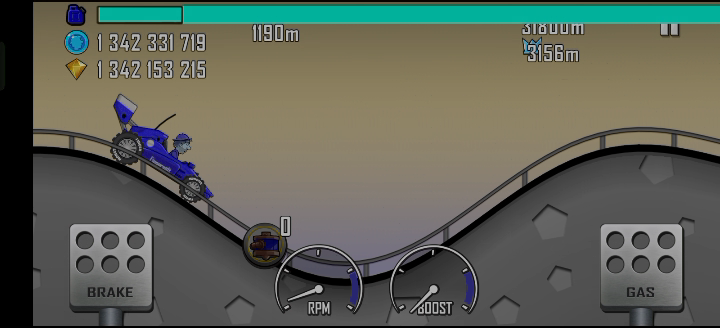

OCR: 1190m
----------


In [ ]:
# abc
# for i in range(1000):
#     clear_output()
#
#     frame = get_frame(cap)
#     frame_img = Image.fromarray(frame)
#
#     h, w = frame.shape[:2]
#     print(f"height: {h}  width: {w}")
#
#     display(frame_img)
#
#     display(
#         Image.fromarray(get_distance_img(frame))
#     )
#
#     Image.fromarray(get_distance_img(frame)).save('abc.png')
#
#     print('OCR:', recognize_digit(get_distance_img(frame)))
#
#     print('-' * 10)
#     time.sleep(0.1)

# Train the model

In [6]:
class HillClimbRacerV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 19 * 19, 128),  # input size matches 34x83 → (34-5)//2+1=15 → wait, recalc properly
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.net(x)


# Initialize model
device = torch.device('cuda')
model = HillClimbRacerV1().to(device)
model.eval()


# If you have a saved model, load it:
# model.load_state_dict(torch.load('your_model.pth', map_location=device))

def preprocess_frame(frame):
    """Convert raw frame to model input tensor (1, 1, H, W)"""
    # Example: crop, resize, grayscale, normalize
    # ADJUST CROP/RESIZE TO YOUR GAME UI
    cropped = frame[100:900, 200:2200]  # adjust based on your screen
    resized = cv2.resize(cropped, (84, 84))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    tensor = torch.from_numpy(gray).float() / 255.0
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # (1, 1, 84, 84)
    return tensor.to(device)


def get_action_from_model(frame):
    tensor = preprocess_frame(frame)
    with torch.no_grad():
        logits = model(tensor)
        pred = torch.argmax(logits, dim=1).item()
    actions = ["accel", "brake", "none"]
    return actions[pred]

In [7]:
import torch.optim as optim
from collections import deque

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HillClimbRacerV1().to(device)
# model.load_state_dict(torch.load("assets/hillclimb_rl_model-001.pth", map_location=device))
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # slightly higher LR for faster initial learning

current_action = None
current_hold_proc = None
saved_log_probs = []
saved_rewards = []
timings = []
step = 0

baseline = 0.0
baseline_alpha = 0.90

last_distance = 0
episode_distance = 0


def parse_distance(text: str) -> int:
    try:
        if text.endswith('m'):
            return int(text[:-1])
        return int(text)
    except:
        return 0

In [12]:
try:
    if cap.isOpened():
        cap.release()
    cap = cv2.VideoCapture(VIDEO_DEVICE)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open {VIDEO_DEVICE}")

    # while True:
    for _ in range(10_000):
        start_iter = time.perf_counter()

        ret, frame = cap.read()
        if not ret:
            time.sleep(0.01)
            continue

        # >>> CRITICAL: NO torch.no_grad() HERE <<<
        tensor = preprocess_frame(frame)
        logits = model(tensor)  # keep gradients!
        probs = torch.softmax(logits, dim=1)
        dist = torch.distributions.Categorical(probs)
        action_idx = dist.sample()
        log_prob = dist.log_prob(action_idx)

        actions = ["accel", "brake", "none"]
        new_action = actions[action_idx.item()]

        # Execute new action
        if new_action != current_action:
            if current_hold_proc is not None:
                current_hold_proc.terminate()
                current_hold_proc = None

            if new_action in ["accel", "brake"]:
                pos = ACCEL_POS if new_action == "accel" else BRAKE_POS
                # Tap + hold
                subprocess.run([
                    'adb', 'shell', 'input', 'swipe',
                    str(pos[0]), str(pos[1]), str(pos[2]), str(pos[3]), str(TAP_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                current_hold_proc = subprocess.Popen([
                    'adb', 'shell', 'input', 'swipe',
                    str(pos[0]), str(pos[1]), str(pos[2]), str(pos[3]), str(HOLD_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

            current_action = new_action

        # Get reward
        dist_img = get_distance_img(frame)
        ocr_text = recognize_digit(dist_img)
        current_dist_val = parse_distance(ocr_text)

        distance_gain = max(0, current_dist_val - last_distance)
        last_distance = current_dist_val

        # Stronger time penalty to discourage inaction
        time_penalty = -0.1  # was -0.01 → now more punishing
        reward = float(distance_gain) + time_penalty
        episode_distance += distance_gain

        saved_log_probs.append(log_prob)
        saved_rewards.append(reward)

        # Update every 30 steps (faster feedback)
        if step > 0 and step % 30 == 0:
            R = sum(saved_rewards)
            baseline = baseline_alpha * baseline + (1 - baseline_alpha) * R

            # Compute policy loss
            policy_loss = []
            for log_prob in saved_log_probs:
                policy_loss.append(-log_prob * (R - baseline))
            loss = torch.stack(policy_loss).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Clear buffers
            saved_log_probs = []
            saved_rewards = []

            print(f" ↳ Update | Gain: {episode_distance}m | Return: {R:+.2f} | Loss: {loss.item():.3f}")

        # Stats
        iter_time = time.perf_counter() - start_iter
        timings.append(iter_time)
        if len(timings) > 100:
            timings = timings[-100:]
        fps = 1.0 / (sum(timings) / len(timings)) if timings else 0
        print(f"[{step}] Dist: {current_dist_val}m | Rew: {reward:+.3f} | FPS: {fps:.1f}")

        step += 1
        time.sleep(0.02)  # slight throttle

except KeyboardInterrupt:
    print("\n🛑 Training interrupted.")
    if current_hold_proc is not None:
        current_hold_proc.terminate()
    cap.release()

[400] Dist: 8m | Rew: -0.100 | FPS: 115.3
[401] Dist: 8m | Rew: -0.100 | FPS: 115.8
[402] Dist: 8m | Rew: -0.100 | FPS: 115.6
[403] Dist: 8m | Rew: -0.100 | FPS: 115.7
[404] Dist: 8m | Rew: -0.100 | FPS: 116.1
[405] Dist: 8m | Rew: -0.100 | FPS: 116.7
[406] Dist: 8m | Rew: -0.100 | FPS: 117.2
[407] Dist: 8m | Rew: -0.100 | FPS: 117.8
[408] Dist: 8m | Rew: -0.100 | FPS: 117.9
[409] Dist: 8m | Rew: -0.100 | FPS: 118.1
[410] Dist: 8m | Rew: -0.100 | FPS: 118.3
[411] Dist: 8m | Rew: -0.100 | FPS: 118.1
[412] Dist: 8m | Rew: -0.100 | FPS: 118.2
[413] Dist: 8m | Rew: -0.100 | FPS: 118.3
[414] Dist: 8m | Rew: -0.100 | FPS: 118.4
[415] Dist: 8m | Rew: -0.100 | FPS: 118.2
[416] Dist: 8m | Rew: -0.100 | FPS: 118.6
[417] Dist: 8m | Rew: -0.100 | FPS: 118.1
[418] Dist: 8m | Rew: -0.100 | FPS: 118.2
[419] Dist: 8m | Rew: -0.100 | FPS: 118.1
 ↳ Update | Gain: 51m | Return: -3.00 | Loss: -0.000
[420] Dist: 8m | Rew: -0.100 | FPS: 114.6
[421] Dist: 8m | Rew: -0.100 | FPS: 114.9
[422] Dist: 8m | Rew: -

In [12]:

# Optionally save model
save_path = "assets/hillclimb_rl_model-001.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to {save_path}")
print(f"Final distance reached: {last_distance}m")

✅ Model saved to assets/hillclimb_rl_model-001.pth
Final distance reached: 1028m


# Run model live

In [ ]:
import cv2
import torch
import time

# Load trained model
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HillClimbRacerV1().to(device)
model.load_state_dict(torch.load("hillclimb_rl_model.pth", map_location=device))
model.eval()

actions = ["accel", "brake", "none"]


def run_live_agent(cap):
    prev_action = None
    current_hold = None

    while True:
        frame = get_frame(cap)
        state = resize_img(frame, width=84)
        tensor = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device) / 255.0

        with torch.no_grad():
            q_vals = model(tensor)
            action_idx = q_vals.argmax().item()

        new_action = actions[action_idx]

        # Execute action (use your existing hold logic here)
        if new_action != prev_action:
            if current_hold:
                current_hold.terminate()
            if new_action == "accel":
                current_hold = subprocess.Popen([
                    'adb', 'shell', 'input', 'swipe', '200', '850', '240', '850', '10000'
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            elif new_action == "brake":
                current_hold = subprocess.Popen([
                    'adb', 'shell', 'input', 'swipe', '2115', '850', '2200', '850', '10000'
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            else:
                current_hold = None
            prev_action = new_action

        time.sleep(0.05)

# === RUN LIVE ===
# cap = cv2.VideoCapture('/dev/video10')
# run_live_agent(cap)